In [1]:
# Import necessari
import cv2
import numpy as np
import os
import pickle
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import json
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
import os
import glob
from PIL import Image
import os
import glob
from PIL import Image

class ParkingLotDataset(Dataset):
    def __init__(self, root_img, root_msk, pairs=None, transforms=None, mask_transforms=None):
        self.root_img = root_img
        self.root_msk = root_msk
        self.transforms = transforms
        self.mask_transforms = mask_transforms

        if pairs is None:
            # Get all image files
            self.image_paths = sorted(glob.glob(os.path.join(root_img, '*.png')))

            # Get all mask files
            self.mask_paths = sorted(glob.glob(os.path.join(root_msk, '*.png')))

            # Pair image and mask files based on their filenames
            #self.pairs = [(image_path, mask_path) for image_path in self.image_paths for mask_path in self.mask_paths if os.path.splitext(os.path.basename(image_path))[0] == os.path.splitext(os.path.basename(mask_path))[0]]
            self.pairs = []

            for image_path in self.image_paths:
                image_filename = os.path.splitext(os.path.basename(image_path))[0]
                mask_filename = f"{image_filename}_SegmentationClass.png"
                mask_path = os.path.join(root_msk, mask_filename)
                if os.path.exists(mask_path):
                    self.pairs.append((image_path, mask_path))

        else:
            self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx, threshold=0.5):
        image_path, mask_path = self.pairs[idx]

        # Load image
        image = Image.open(image_path)
        image_array = np.array(image)
        self.input_channels = image_array.shape[0]

        # Apply transformations
        if self.transforms:
            image_array = self.transforms(image_array)
        
        #mask = Image.open(mask_path)
        #mask_array = np.array(mask)
        mask_array = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask_array = (mask_array > threshold).astype(np.float32)
        self.input_channels = mask_array.shape[0]

        # Apply transformations
        if self.mask_transforms:
            mask_array = self.mask_transforms(mask_array)


        return image_array, mask_array
        


In [3]:
import random
from torch.utils.data import random_split
from torchvision.transforms import functional as F

# magari rifare il dataloader con due cartelle
train_path = '/kaggle/input/d-organ/train_images_2'
train_mask_path = '/kaggle/input/d-organ/train_masks'

val_path = '/kaggle/input/d-organ/val_images'
val_mask_path = '/kaggle/input/d-organ/val_masks'

test_path = '/kaggle/input/d-organ/test_images'
test_mask_path = '/kaggle/input/d-organ/test_masks'

#normalize = transforms.Normalize(mean=[0.5], std=[0.5])
#normalize = transforms.Normalize(mean=[35.5, 35.2, 33.4], std=[21.8, 21.6, 20.9])

transform = transforms.Compose([
    
    transforms.ToTensor(),
    
    #transforms.Normalize(mean=[35.5, 35.2, 33.4], std=[21.8, 21.6, 20.9]),
    # Add other transforms here as needed
])

mask_transforms = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5], std=[0.5]),
    # Add other mask transformations here
])



# Create datasets for each split
train_dataset = ParkingLotDataset(train_path, train_mask_path, transforms=transform, mask_transforms=mask_transforms)
val_dataset = ParkingLotDataset(val_path, val_mask_path, transforms=transform, mask_transforms=mask_transforms)
test_dataset = ParkingLotDataset(test_path, test_mask_path, transforms=transform, mask_transforms=mask_transforms)

# Now you can create data loaders for each split
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False) 

In [4]:
from torch.utils.data import DataLoader
from torch import optim
import torch.nn.functional as F
import wandb
from torch.optim.lr_scheduler import StepLR
from torch import save
from torch.optim.lr_scheduler import ReduceLROnPlateau
!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp
wandb.login(key='cf05b564865bb4bf8601ed59cbace5b02a587fa9')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Load the pretrained U-Net model
model = smp.Linknet(
    encoder_name="resnet34",  # Choose the encoder (backbone)
    encoder_weights="imagenet",  # Use pre-trained weights from ImageNet
    in_channels=3,  # Input channels (RGB)
    classes=1,  # Binary segmentation
)

# Move the model to the device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 10
run = wandb.init(
    #Set the project where this run will be logged
    project="Parking_lot_zones",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": 0.01,
        "epochs": epochs,
    },
    #entity='lorenzo_barbieri'
    entity='occelli-2127855'
)

# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device, dtype=torch.float32)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    wandb.log({"Train Loss": train_loss})

    # Validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device, dtype=torch.float32)

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    wandb.log({"Validation Loss": val_loss})

    print(f"Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=30e27d987a69822601bf31f31118177aa2588e638d46371f7b3282e9a645ef25
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=b21e80170e467c4dccc2281c0c4ef6bea66e5875a2c6fa3ffce66e904301530f
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficien

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 236MB/s]
wandb: Currently logged in as: occelli-2127855. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240621_145300-04s46q90
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run solar-lake-62
wandb: ⭐️ View project at https://

Epoch 1, Training Loss: 0.5361, Validation Loss: 0.4317
Epoch 2, Training Loss: 0.3361, Validation Loss: 0.3429
Epoch 3, Training Loss: 0.2648, Validation Loss: 0.2906
Epoch 4, Training Loss: 0.2316, Validation Loss: 0.2644
Epoch 5, Training Loss: 0.2087, Validation Loss: 0.2586
Epoch 6, Training Loss: 0.1945, Validation Loss: 0.2490
Epoch 7, Training Loss: 0.1766, Validation Loss: 0.2581
Epoch 8, Training Loss: 0.1638, Validation Loss: 0.2570
Epoch 9, Training Loss: 0.1668, Validation Loss: 0.2800
Epoch 10, Training Loss: 0.1524, Validation Loss: 0.2603


In [ ]:
import numpy as np

def iou_score(pred, target):
    intersection = np.logical_and(pred, target)
    union = np.logical_or(pred, target)
    return np.sum(intersection) / np.sum(union)

def dice_coefficient(pred, target):
    intersection = np.sum(pred * target)
    return (2. * intersection) / (np.sum(pred) + np.sum(target))

def precision_score(pred, target):
    true_positive = np.sum(np.logical_and(pred, target))
    predicted_positive = np.sum(pred)
    return true_positive / predicted_positive if predicted_positive > 0 else 0

def recall_score(pred, target):
    true_positive = np.sum(np.logical_and(pred, target))
    actual_positive = np.sum(target)
    return true_positive / actual_positive if actual_positive > 0 else 0

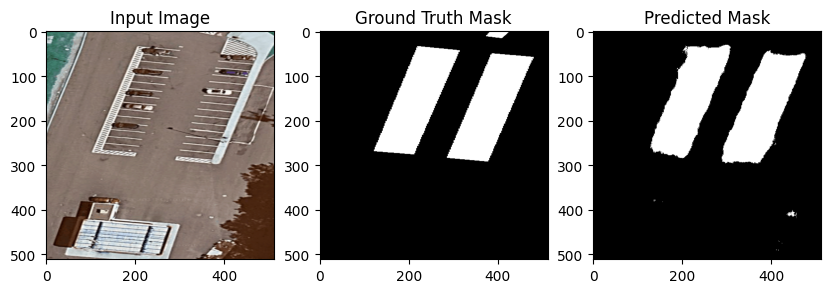

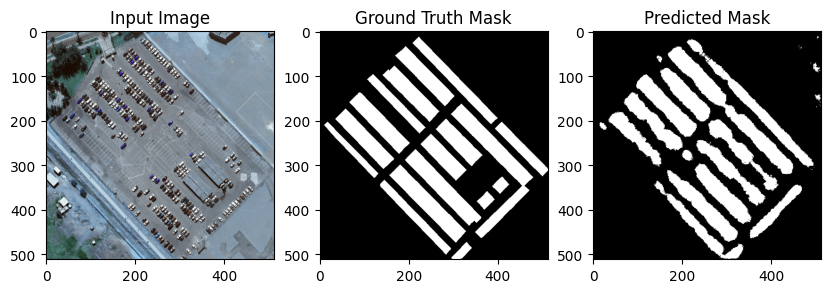

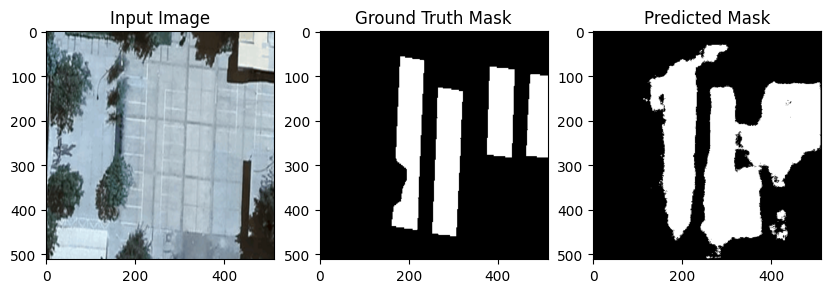

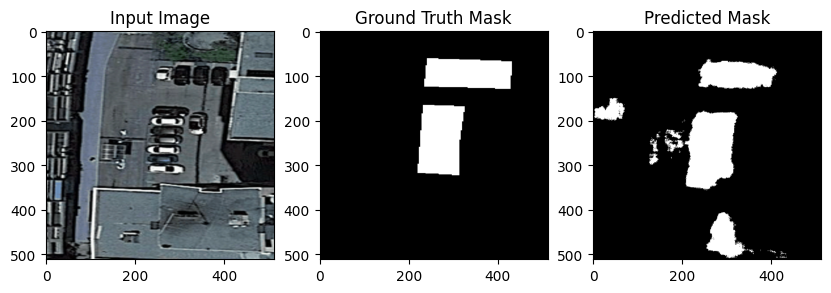

Accuracy on test set: 91.61%
Precision: 0.8711
Recall: 0.8531


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:   Test Accuracy ▁
wandb:  Test Precision ▁
wandb:     Test Recall ▁
wandb:      Train Loss █▄▃▂▂▂▁▁▁▁
wandb: Validation Loss █▅▃▂▁▁▁▁▂▁
wandb: 
wandb: Run summary:
wandb:   Test Accuracy 91.60807
wandb:  Test Precision 0.87114
wandb:     Test Recall 0.8531
wandb:      Train Loss 0.15242
wandb: Validation Loss 0.26026
wandb: 
wandb: 🚀 View run solar-lake-62 at: https://wandb.ai/occelli-2127855/Parking_lot_zones/runs/04s46q90
wandb: ⭐️ View project at: https://wandb.ai/occelli-2127855/Parking_lot_zones
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20240621_145300-04s46q90/logs


In [5]:
import torch
import os
from PIL import Image
import numpy as np

# Create directories to save images
save_dir = '/kaggle/working/segmentation_results_pretrained'
os.makedirs(os.path.join(save_dir, 'input_images'), exist_ok=True)
os.makedirs(os.path.join(save_dir, 'ground_truth'), exist_ok=True)
os.makedirs(os.path.join(save_dir, 'predictions'), exist_ok=True)


model.eval()

total = 0
correct = 0
total_iou = 0
total_dice = 0
total_precision = 0
total_recall = 0
num_samples = 0

with torch.no_grad():
    for batch_idx, batch in enumerate(test_loader):
        images, masks = batch[:2]
        images = images.to(device)
        masks = masks.to(device, dtype=torch.float32)
        outputs = model(images)
        predicted = (outputs > 0.5).float()
        
        total += masks.numel()
        correct += (predicted == masks).sum().item()
        
        # Calculate additional metrics and save images
        for i in range(images.size(0)):
            pred_np = predicted[i][0].cpu().numpy()
            mask_np = masks[i][0].cpu().numpy()
            
            total_iou += iou_score(pred_np, mask_np)
            total_dice += dice_coefficient(pred_np, mask_np)
            total_precision += precision_score(pred_np, mask_np)
            total_recall += recall_score(pred_np, mask_np)
            num_samples += 1
            
            # Save input image
            input_img = Image.fromarray((images[i].permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8))
            input_img.save(os.path.join(save_dir, 'input_images', f'input_{batch_idx}_{i}.png'))
            
            # Save ground truth mask
            gt_mask = Image.fromarray((mask_np * 255).astype(np.uint8))
            gt_mask.save(os.path.join(save_dir, 'ground_truth', f'gt_{batch_idx}_{i}.png'))
            
            # Save predicted mask
            pred_mask = Image.fromarray((pred_np * 255).astype(np.uint8))
            pred_mask.save(os.path.join(save_dir, 'predictions', f'pred_{batch_idx}_{i}.png'))

accuracy = 100 * correct / total
mean_iou = total_iou / num_samples
mean_dice = total_dice / num_samples
mean_precision = total_precision / num_samples
mean_recall = total_recall / num_samples

print(f"Accuracy on test set: {accuracy:.2f}%")
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Dice Coefficient: {mean_dice:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")

# Log metrics to wandb
wandb.log({
    "Test Accuracy": accuracy,
    "Mean IoU": mean_iou,
    "Mean Dice Coefficient": mean_dice,
    "Mean Precision": mean_precision,
    "Mean Recall": mean_recall
})

print(f"Images saved in {save_dir}")

wandb.finish()